## Testing Video



*   The File Path must be in the exact order
*   Colab Pro is need, since GPU access is crucial for this code
*   The video files must be in mp4 format
*   Save the station in drive folder under '/fly_fall_test_videos' and save the mp4 files there



In [1]:
# Connect to Google Drive
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/
Mounted at /content/gdrive


In [2]:
# Create a symlink to yoloV4 directory
!ln -s /content/gdrive/Shareddrives/Falls\ project\ materials\ March\ 2024/yoloV4 /content/yoloV4

In [3]:
# The base path for the project materials in Google Drive
base_drive_path = "/content/yoloV4"

# Path to the configuration folder where yolov4-custom.cfg is located
config_folder = f"{base_drive_path}/darknet/cfg"

# Path to the trained YOLOv4 weights file
training_weights = f"{base_drive_path}/training/yolov4-custom_last.weights"

In [4]:
# Change to yolov4 directory
%cd {base_drive_path}

/content/gdrive/Shareddrives/Falls project materials March 2024/yoloV4


In [5]:

# Change to darknet directory
%cd darknet/

# Enable OpenCV, GPU, CUDNN, and LIBSO in the Makefile
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/gdrive/Shareddrives/Falls project materials March 2024/yoloV4/darknet


In [6]:
# Clean and Compile Darknet
!make clean
!make

rm -rf ./obj/image_opencv.o ./obj/http_stream.o ./obj/gemm.o ./obj/utils.o ./obj/dark_cuda.o ./obj/convolutional_layer.o ./obj/list.o ./obj/image.o ./obj/activations.o ./obj/im2col.o ./obj/col2im.o ./obj/blas.o ./obj/crop_layer.o ./obj/dropout_layer.o ./obj/maxpool_layer.o ./obj/softmax_layer.o ./obj/data.o ./obj/matrix.o ./obj/network.o ./obj/connected_layer.o ./obj/cost_layer.o ./obj/parser.o ./obj/option_list.o ./obj/darknet.o ./obj/detection_layer.o ./obj/captcha.o ./obj/route_layer.o ./obj/writing.o ./obj/box.o ./obj/nightmare.o ./obj/normalization_layer.o ./obj/avgpool_layer.o ./obj/coco.o ./obj/dice.o ./obj/yolo.o ./obj/detector.o ./obj/layer.o ./obj/compare.o ./obj/classifier.o ./obj/local_layer.o ./obj/swag.o ./obj/shortcut_layer.o ./obj/representation_layer.o ./obj/activation_layer.o ./obj/rnn_layer.o ./obj/gru_layer.o ./obj/rnn.o ./obj/rnn_vid.o ./obj/crnn_layer.o ./obj/demo.o ./obj/tag.o ./obj/cifar.o ./obj/go.o ./obj/batchnorm_layer.o ./obj/art.o ./obj/region_layer.o ./obj

In [7]:
# Copy Custom YOLOv4 Configuration and Data Files
!cp {base_drive_path}/yolov4-custom.cfg cfg
!cp {base_drive_path}/obj.names data
!cp {base_drive_path}/obj.data data

In [8]:
# Adjust Configuration for Testing
%cd {config_folder}
!sed -i 's/batch=64/batch=1/' yolov4-custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov4-custom.cfg
%cd ..

/content/gdrive/Shareddrives/Falls project materials March 2024/yoloV4/darknet/cfg
/content/gdrive/Shareddrives/Falls project materials March 2024/yoloV4/darknet


In [9]:
# Path to the folder containing the input video
video_input_folder = f"{base_drive_path}/fly_fall_test_videos/New_test_video"
# Name of the video file to be processed
video_file_name = "JT_test_10-6-24.mp4"

# Path to the output video file where detected objects are saved
output_video_file = f"{video_input_folder}/JT_test_10-6-24_detected.avi"
# # Path to the text file where bounding box coordinates are saved
output_text_file = f"{base_drive_path}/darknet/box_coordinate.txt"

In [10]:
import os

file_path = output_text_file

# Check if the file exists and delete it
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"{file_path} has been deleted.")
else:
    print(f"The file {file_path} does not exist.")

new_file_path = output_text_file

with open(new_file_path, 'w') as file:
    pass  # 'pass' will create an empty file
print(f"An empty file has been created at {file_path}")

/content/yoloV4/darknet/box_coordinate.txt has been deleted.
An empty file has been created at /content/yoloV4/darknet/box_coordinate.txt


In [11]:
# Create an empty output text file for storing box coordinates

%%writefile {output_text_file}

Overwriting /content/yoloV4/darknet/box_coordinate.txt


In [12]:
# Run YOLOv4 Object Detection

!./darknet detector demo data/obj.data cfg/yolov4-custom.cfg {training_weights} \
-dont_show "{video_input_folder}/{video_file_name}" -thresh 0.5 -i 0 \
-out_filename "{output_video_file}" -ext_output > {output_text_file}

 CUDA-version: 12020 (12020), cuDNN: 8.9.6, CUDNN_HALF=1, GPU count: 1  
 OpenCV version: 4.5.4
Cannot load image data/labels/32_0.png
Cannot load image data/labels/33_0.png
Cannot load image data/labels/34_0.png
Cannot load image data/labels/35_0.png
Cannot load image data/labels/36_0.png
Cannot load image data/labels/37_0.png
Cannot load image data/labels/38_0.png
Cannot load image data/labels/39_0.png
Cannot load image data/labels/40_0.png
Cannot load image data/labels/41_0.png
Cannot load image data/labels/42_0.png
Cannot load image data/labels/43_0.png
Cannot load image data/labels/44_0.png
Cannot load image data/labels/45_0.png
Cannot load image data/labels/46_0.png
Cannot load image data/labels/47_0.png
Cannot load image data/labels/48_0.png
Cannot load image data/labels/49_0.png
Cannot load image data/labels/50_0.png
Cannot load image data/labels/51_0.png
Cannot load image data/labels/52_0.png
Cannot load image data/labels/53_0.png
Cannot load image data/labels/54_0.png
Cannot 

## Calculate No. of Falls

In [13]:
# Import packages
import re
import csv
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime, timedelta

In [15]:
# Input and output file paths
input_file_path = f"{base_drive_path}/darknet/box_coordinate.txt"
# input_file_path = "/content/box_coordinate.txt"
output_file_path_BCP = f"{base_drive_path}/darknet/box_coordinate_processed.csv"

# Regular expression pattern to extract the desired information
pattern = r'SN3 Present_fly: (\d+)%\s+\(left_x:\s+(\d+)\s+top_y:\s+(\d+)\s+width:\s+(\d+)\s+height:\s+(\d+)\)'

# Process content and write to CSV file
with open(input_file_path, 'r') as input_file, open(output_file_path_BCP, 'w', newline='') as output_file:
    csv_writer = csv.writer(output_file)
    csv_writer.writerow(['Serial number', 'left_x', 'top_y', 'width', 'height'])

    for i, line in enumerate(input_file, 1):
        # Extract values using regex
        match = re.match(pattern, line)
        if match:
            percentage, left_x, top_y, width, height = match.groups()
            csv_writer.writerow([i, int(left_x), int(top_y), int(width), int(height)])

In [16]:
# CSV file path on Google Drive
csv_file_path = output_file_path_BCP

# Read CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Add a new column "second" with calculated values - 30 is the frames per second.
df["second"] = df["Serial number"]/30

# Display the DataFrame with the new column
print(df)

df.to_csv(csv_file_path, index=False)

      Serial number  left_x  top_y  width  height      second
0                14     320     84    109      46    0.466667
1                16     320     84    111      45    0.533333
2                18     322     83    109      46    0.600000
3                20     323     83    107      46    0.666667
4                22     321     83    110      46    0.733333
...             ...     ...    ...    ...     ...         ...
2536           5086     326     81    102      48  169.533333
2537           5088     325     80    104      49  169.600000
2538           5090     326     80    103      49  169.666667
2539           5092     327     81    102      49  169.733333
2540           5094     327     80    100      52  169.800000

[2541 rows x 6 columns]


In [17]:
# CSV file path on Google Drive
csv_file_path = output_file_path_BCP
output_file_path = f"{base_drive_path}/darknet/box_coordinate_processed_bkp_with_delta_y.csv"


# Read CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Add a new column "delta_y" with the difference between current top_y and previous top_y
df['delta_y'] = df['top_y'].diff()

# Save the modified DataFrame back to the CSV file
df.to_csv(output_file_path, index=False)

# Display the modified DataFrame
print(df.head())

   Serial number  left_x  top_y  width  height    second  delta_y
0             14     320     84    109      46  0.466667      NaN
1             16     320     84    111      45  0.533333      0.0
2             18     322     83    109      46  0.600000     -1.0
3             20     323     83    107      46  0.666667      0.0
4             22     321     83    110      46  0.733333      0.0


### 3-D Scatter Plot

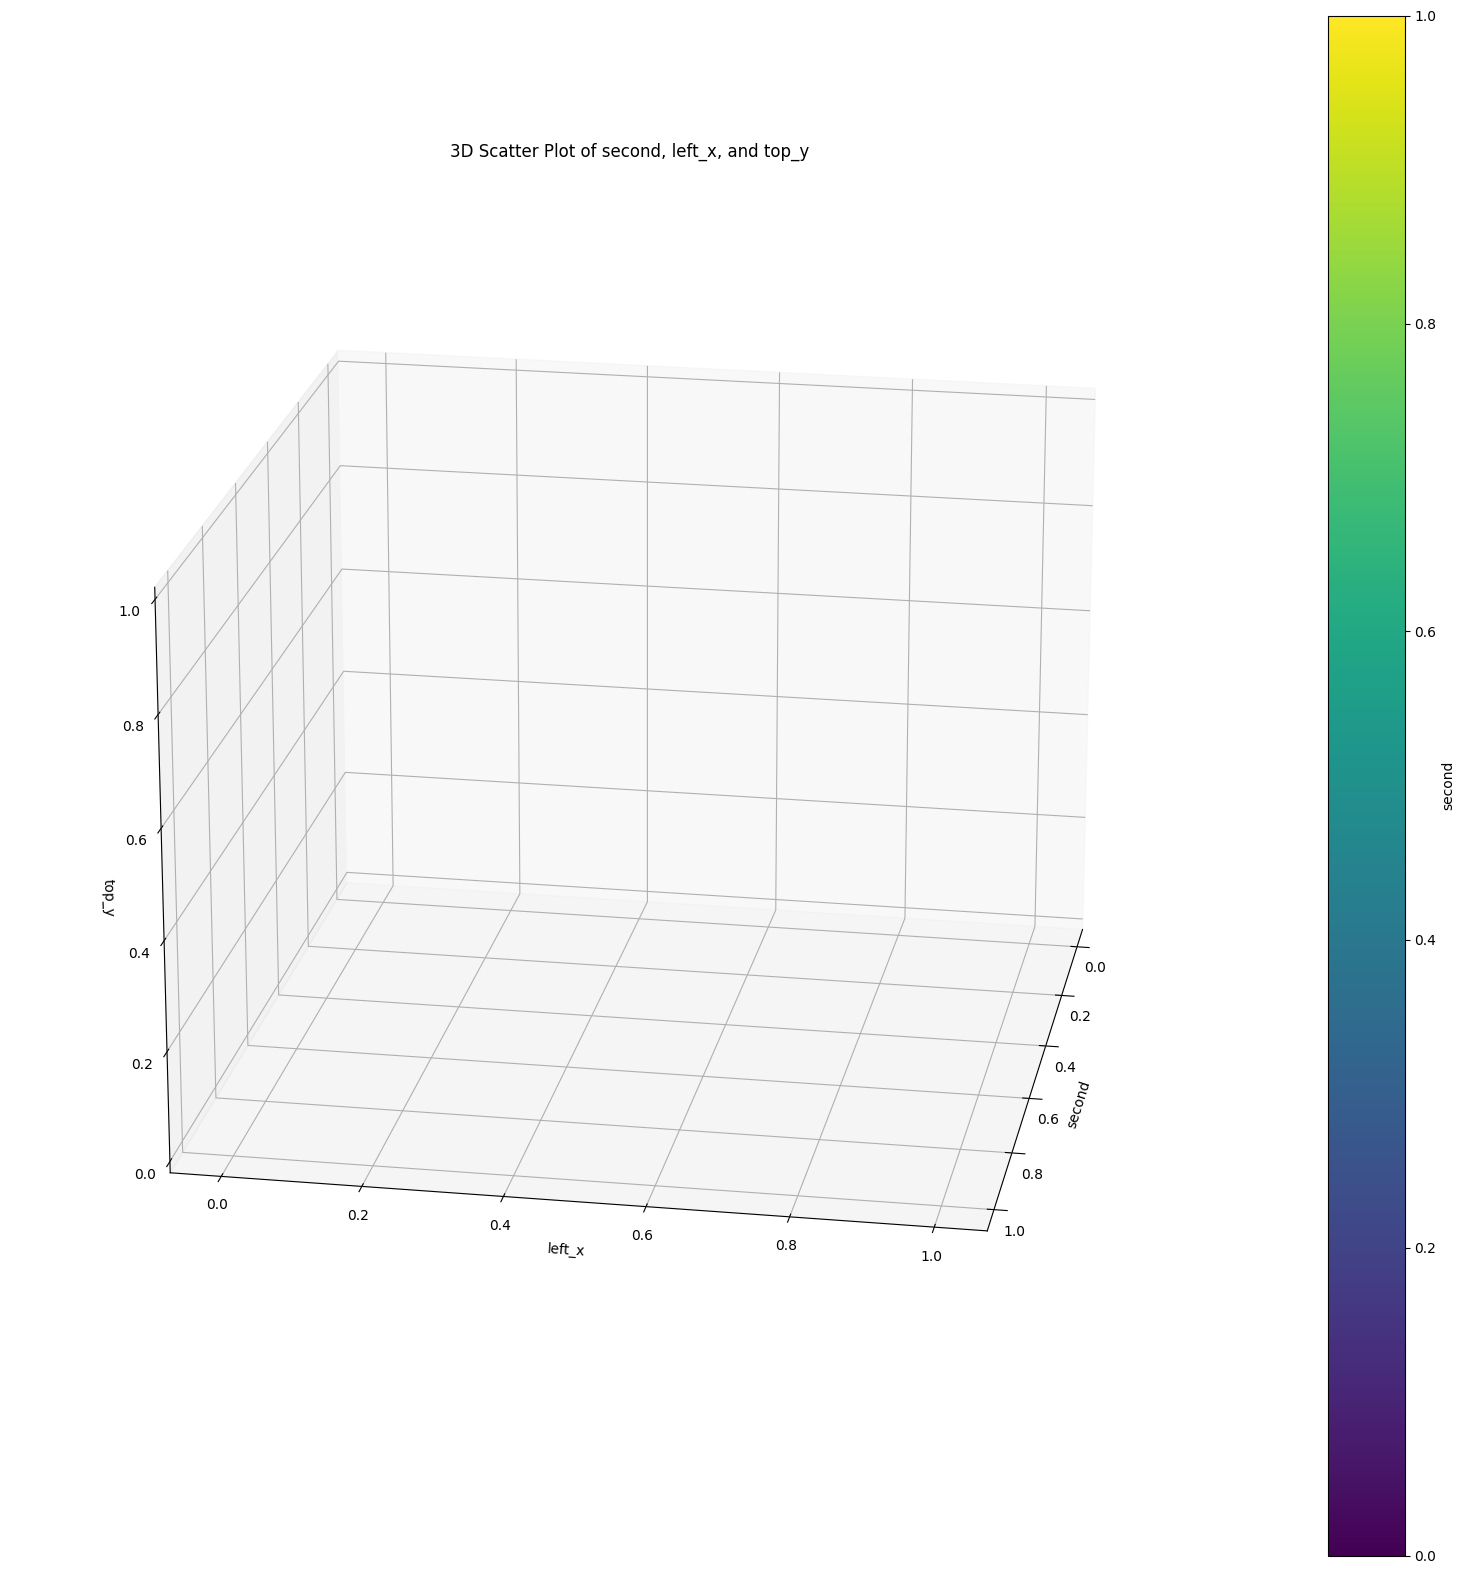

In [18]:
# CSV file path on Google Drive
csv_file_path = output_file_path_BCP

# Read CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

df_filtered = df[(df['second'] > 2151) & (df['second'] < 2181)] #597 fly falls

# Create a 3D scatter plot
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')
marker_size = 1000

# Plot the data points in 3D
scatter = ax.scatter(df_filtered['second'], df_filtered['left_x'], df_filtered['top_y'], c=df_filtered['second'], cmap='viridis', marker='o', s=marker_size, label='Data Points')
# scatter = ax.scatter(df['second'], df['left_x'], df['top_y'], c=df['second'], cmap='viridis', marker='o', s=marker_size, label='Data Points')


# Set labels for the axes
ax.set_xlabel('second')
ax.set_ylabel('left_x')
ax.set_zlabel('top_y')

# Add a colorbar for the 'second' values
colorbar = plt.colorbar(scatter, ax=ax, label='second')

# Set the viewing angle
ax.view_init(elev=20, azim=10) #90

# Show the plot
plt.title('3D Scatter Plot of second, left_x, and top_y')
plt.show()


### Predicted values written to csv, keeping fall threshold = 60 units in y coordinate values

In [19]:
# CSV file path on Google Drive
csv_file_path = f"{base_drive_path}/darknet/box_coordinate_processed_bkp_with_delta_y.csv"

# Read CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Add a new column "Fall" based on the condition delta_y > 90
df['Fall'] = df['delta_y'] > 60
# df['Fall'] = df['delta_y'] < -60

# Save the modified DataFrame back to the CSV file
df.to_csv(csv_file_path, index=False)

# Display the modified DataFrame
print(df.head())


   Serial number  left_x  top_y  width  height    second  delta_y   Fall
0             14     320     84    109      46  0.466667      NaN  False
1             16     320     84    111      45  0.533333      0.0  False
2             18     322     83    109      46  0.600000     -1.0  False
3             20     323     83    107      46  0.666667      0.0  False
4             22     321     83    110      46  0.733333      0.0  False


In [20]:
# Define file paths
predictions_path = f"{base_drive_path}/darknet/box_coordinate_processed_bkp_with_delta_y.csv"

# Read predictions file
predictions_df = pd.read_csv(predictions_path)

# Filter rows where "Fall" column is True
predicted_falls_df = predictions_df[predictions_df['Fall']]


In [21]:
# Total Number of Predicted Falls
total_predicted_falls = predicted_falls_df['Fall'].sum()
print(f'Total Predicted Falls: {total_predicted_falls}')


Total Predicted Falls: 0


## Calculate Time Stamps

### Split the Video frame by frame

In [ ]:
!chmod +x darknet

In [ ]:
import cv2
from tqdm import tqdm

# Open the video file
video_file = f"{base_drive_path}/fly_fall_test_videos/5-26-19-IR/AviFileChunk18_View0.mp4"
video = cv2.VideoCapture(video_file)

# Get the total number of frames in the video
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

# Create a directory to store the frames
!mkdir -p "/content/frames/"
!rm -rf /content/frames/*

# Initialize the current frame counter
current_frame = 0

# Loop over the frames of the video with tqdm progress bar
with tqdm(total=total_frames, desc="Processing frames") as pbar:
    while True:
        # Read the next frame
        ret, frame = video.read()

        # If the frame is empty, break out of the loop
        if not ret:
            break

        # Save the frame as a JPG file in the frames directory
        cv2.imwrite("/content/frames/frame{:06d}.jpg".format(current_frame), frame)

        # Increment the current frame counter
        current_frame += 1

        # Update the progress bar
        pbar.update(1)

# Release the video capture object
video.release()

In [ ]:
! ls /content/frames/ | awk '{print "/content/frames/" $1}' > /content/train.txt

In [ ]:
# Run YOLOv4 Object Detection

!./darknet detector demo data/obj.data cfg/yolov4-custom.cfg {training_weights} \
-dont_show "{video_input_folder}/{video_file_name}" -thresh 0.5 -i 0 \
-out_filename "{output_video_file}" -ext_output > {output_text_file}

In [ ]:
! ./darknet detector test data/obj.data cfg/yolov4-custom.cfg {training_weights} \
-dont_show -thresh 0.5 < /content/train.txt > /content/result.txt

In [ ]:
!cp /content/result.txt /content/gdrive/MyDrive/Colab\ Notebooks/Fall_project/

### Formate the data

In [1]:
import re
import csv
import os
import pandas as pd
from datetime import datetime, timedelta

In [3]:
# Define the regular expressions for matching the required data
frame_regex = re.compile(r'/content/frames/(frame\d{6})\.jpg')
present_fly_regex = re.compile(r'Present_fly: \d+%')
bbox_regex = re.compile(r'Bounding Box.*: Left=(\d+), Top=(\d+), Right=(\d+), Bottom=(\d+)')

# Initialize variables
frame_data = []
serial_number = 1

# Read the input text file
with open('/content/result.txt', 'r') as file:
    lines = file.readlines()
    current_frame = None
    for line in lines:
        frame_match = frame_regex.search(line)
        if frame_match:
            current_frame = frame_match.group(1)
            frame_data.append([serial_number, current_frame, "Absent_fly", 0, 0, 0, 0])
            serial_number += 1

        if current_frame:
            present_fly_match = present_fly_regex.search(line)
            if present_fly_match:
                frame_data[-1][2] = "Present_fly"

            bbox_match = bbox_regex.search(line)
            if bbox_match:
                left_x = int(bbox_match.group(1))
                top_y = int(bbox_match.group(2))
                right_x = int(bbox_match.group(3))
                bottom_y = int(bbox_match.group(4))
                width = right_x - left_x
                height = bottom_y - top_y
                frame_data[-1][3] = left_x
                frame_data[-1][4] = top_y
                frame_data[-1][5] = width
                frame_data[-1][6] = height

# Convert to DataFrame
df = pd.DataFrame(frame_data, columns=['Serial number', 'Frame', 'Fly_status', 'left_x', 'top_y', 'width', 'height'])

# Calculate seconds column
df['seconds'] = df['Serial number'] / 30

# Define file paths
local_file_path = '/content/output.csv'

# Save locally
df.to_csv(local_file_path, index=False)

In [5]:
# Add Delta

# Initialize delta_y column
df['delta_y'] = 0

# Calculate delta_y based on the specified conditions
for i in range(1, len(df)):
    if df.loc[i, 'top_y'] == 0:
        df.loc[i, 'delta_y'] = 0
    else:
        j = i - 1
        while j >= 0 and df.loc[j, 'top_y'] == 0:
            j -= 1
        if j >= 0:
            df.loc[i, 'delta_y'] = df.loc[i, 'top_y'] - df.loc[j, 'top_y']

# Define file paths
local_file_path = '/content/output_with_delta_y.csv'

# Save locally
df.to_csv(local_file_path, index=False)

In [6]:
# Add threshold

df['Fall'] = df['delta_y'] > 60

# Define file paths
local_file_path = '/content/output_with_bkp_delta_y.csv'

# Save locally
df.to_csv(local_file_path, index=False)

In [7]:
# Show True values
true_falls = df[df['Fall'] == True]
true_falls

,Serial number,Frame,Fly_status,left_x,top_y,width,height,seconds,delta_y,Fall
1226,1227,frame001226,Present_fly,480,217,107,49,40.900000,85,True
1559,1560,frame001559,Present_fly,351,188,111,56,52.000000,61,True
1658,1659,frame001658,Present_fly,510,223,42,71,55.300000,85,True
1671,1672,frame001671,Present_fly,476,277,102,59,55.733333,140,True
1681,1682,frame001681,Present_fly,447,311,116,51,56.066667,171,True
...,...,...,...,...,...,...,...,...,...,...
8668,8669,frame008668,Present_fly,475,372,113,55,288.966667,226,True
8679,8680,frame008679,Present_fly,474,371,113,53,289.333333,227,True
8690,8691,frame008690,Present_fly,472,370,113,53,289.700000,226,True
8878,8879,frame008878,Present_fly,414,358,126,50,295.966667,184,True


### Find Timestamp

In [8]:
# Convert to TimeStamps

def convert_seconds(seconds_list):
    result = []
    for seconds in seconds_list:
        # Convert the total seconds to hours, minutes, and remaining seconds
        hours = int(seconds // 3600)
        minutes = int((seconds % 3600) // 60)
        seconds = int(seconds % 60)

        # Format as HH:MM:SS
        formatted_time = f"{hours:02}:{minutes:02}:{seconds:02}"
        result.append(formatted_time)

    return result

# Input seconds list
seconds_list = df['seconds']

# Convert seconds to HH:MM:SS
converted_times = convert_seconds(seconds_list)

# Add the new column to the DataFrame
df['timestamp'] = converted_times


# Identify the indices where falls is True
true_indices = df.index[df['Fall'] == True].tolist()

# Add the row before each True value
all_indices = set(true_indices + [i-1 for i in true_indices if i-1 >= 0])

# Select and print the rows
result_df = df.loc[sorted(all_indices)]

true_falls = df[df['Fall'] == True]

# result_df
true_falls

,Serial number,Frame,Fly_status,left_x,top_y,width,height,seconds,delta_y,Fall,timestamp
1226,1227,frame001226,Present_fly,480,217,107,49,40.900000,85,True,00:00:40
1559,1560,frame001559,Present_fly,351,188,111,56,52.000000,61,True,00:00:52
1658,1659,frame001658,Present_fly,510,223,42,71,55.300000,85,True,00:00:55
1671,1672,frame001671,Present_fly,476,277,102,59,55.733333,140,True,00:00:55
1681,1682,frame001681,Present_fly,447,311,116,51,56.066667,171,True,00:00:56
...,...,...,...,...,...,...,...,...,...,...,...
8668,8669,frame008668,Present_fly,475,372,113,55,288.966667,226,True,00:04:48
8679,8680,frame008679,Present_fly,474,371,113,53,289.333333,227,True,00:04:49
8690,8691,frame008690,Present_fly,472,370,113,53,289.700000,226,True,00:04:49
8878,8879,frame008878,Present_fly,414,358,126,50,295.966667,184,True,00:04:55


In [9]:
# Filter rows where "Fall" column is True
predicted_falls_df = df[df['Fall']]

# Input seconds list
seconds_list = predicted_falls_df['seconds']

# Convert and print the results
converted_times = convert_seconds(seconds_list)
for time in converted_times:
    print(time)

00:00:40
00:00:52
00:00:55
00:00:55
00:00:56
00:00:56
00:00:56
00:00:57
00:00:57
00:00:57
00:00:58
00:00:58
00:00:59
00:00:59
00:00:59
00:01:00
00:01:00
00:01:00
00:01:01
00:01:01
00:01:01
00:01:02
00:01:02
00:01:03
00:01:03
00:01:03
00:01:04
00:01:17
00:01:27
00:01:28
00:01:28
00:01:29
00:01:29
00:01:29
00:01:30
00:01:30
00:01:30
00:01:31
00:01:32
00:01:33
00:01:34
00:01:34
00:01:34
00:01:36
00:01:36
00:01:36
00:01:36
00:01:40
00:01:43
00:01:46
00:01:46
00:01:47
00:01:47
00:01:48
00:01:48
00:01:48
00:01:49
00:01:49
00:01:50
00:01:50
00:01:50
00:01:51
00:01:51
00:01:51
00:01:54
00:01:54
00:01:55
00:01:55
00:01:58
00:02:01
00:02:01
00:02:02
00:02:02
00:02:03
00:02:03
00:02:04
00:02:06
00:02:08
00:02:09
00:02:09
00:02:10
00:02:10
00:02:11
00:02:11
00:02:13
00:02:14
00:02:15
00:02:15
00:02:16
00:02:16
00:02:16
00:02:17
00:02:17
00:02:17
00:02:18
00:02:18
00:02:32
00:02:32
00:02:36
00:02:37
00:02:37
00:02:37
00:02:38
00:02:38
00:02:38
00:02:39
00:02:39
00:02:40
00:02:40
00:02:43
00:02:43
0

In [23]:
# prompt: find max value in column top_y and print the frame number which have top_y greater than 400 and has Fall = True, also print the corresponding timestamps

# Find the maximum value in the 'top_y' column
max_top_y = df['top_y'].max()

# Find rows where 'top_y' is greater than 400 and 'Fall' is True
filtered_rows = df[(df['top_y'] > 440) & (df['Fall'] == True)]

print(len(filtered_rows))

# Print the frame number, top_y value, and timestamp for these rows
for index, row in filtered_rows.iterrows():
  print(f"Frame Number: {row['Frame']}, top_y: {row['top_y']}, Timestamp: {row['timestamp']}")


16
Frame Number: frame001769, top_y: 444, Timestamp: 00:00:59
Frame Number: frame001781, top_y: 450, Timestamp: 00:00:59
Frame Number: frame001792, top_y: 450, Timestamp: 00:00:59
Frame Number: frame001803, top_y: 448, Timestamp: 00:01:00
Frame Number: frame001815, top_y: 449, Timestamp: 00:01:00
Frame Number: frame001825, top_y: 444, Timestamp: 00:01:00
Frame Number: frame001836, top_y: 450, Timestamp: 00:01:01
Frame Number: frame002714, top_y: 444, Timestamp: 00:01:30
Frame Number: frame002725, top_y: 448, Timestamp: 00:01:30
Frame Number: frame002736, top_y: 449, Timestamp: 00:01:31
Frame Number: frame005736, top_y: 441, Timestamp: 00:03:11
Frame Number: frame007880, top_y: 448, Timestamp: 00:04:22
Frame Number: frame007892, top_y: 452, Timestamp: 00:04:23
Frame Number: frame007903, top_y: 447, Timestamp: 00:04:23
Frame Number: frame007914, top_y: 450, Timestamp: 00:04:23
Frame Number: frame007925, top_y: 447, Timestamp: 00:04:24


In [ ]:
# prompt: find max value in column top_y and print the frame number which have top_y greater than 400 and has Fall = True, also print the corresponding timestamps. Show only unique timestamps

# Find the maximum value in the 'top_y' column
max_top_y = df['top_y'].max()

# Find rows where 'top_y' is greater than 400 and 'Fall' is True
filtered_df = df[(df['top_y'] > 440) & (df['Fall'] == True)]

# Extract the frame numbers and timestamps for the filtered rows
frame_numbers = filtered_df['Frame'].tolist()
timestamps = filtered_df['timestamp'].tolist()

# Remove duplicate timestamps
unique_timestamps = []
for timestamp in timestamps:
  if timestamp not in unique_timestamps:
    unique_timestamps.append(timestamp)

# Print the results
print(f"Max top_y: {max_top_y}")
print("Frame Numbers with top_y > 400 and Fall = True:")
for frame_number in frame_numbers:
  print(frame_number)
print("Corresponding Unique Timestamps:")
for timestamp in unique_timestamps:
  print(timestamp)
